In [1]:
import requests
import json
import torch
import torch.nn as nn
import os
from tqdm import tqdm
import transformers
from evaluate import load
from transformers import BertTokenizerFast, AdamW, BertForQuestionAnswering, AutoTokenizer, AutoModelForQuestionAnswering, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import f1_score

In [2]:
# Check if GPU is available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
# File paths
BASE_PATH = "/home/tpittal/DeepLearning/Assignment3/Spoken-SQuAD-master"  # Set your base path here
spoken_train = "spoken_train-v1.1.json"
spoken_test = "spoken_test-v1.1.json"
spoken_test_WER44 = "spoken_test-v1.1_WER44.json"
spoken_test_WER54 = "spoken_test-v1.1_WER54.json"

In [4]:
# Read data function
def read_json(path):
    contexts = []
    questions = []
    answers = []
    
    with open(path, 'r') as file:
        raw_data = json.load(file)

    for group in raw_data['data']:
        for paragraph in group['paragraphs']:
            context = paragraph['context']
            for qa in paragraph['qas']:
                question = qa['question']
                for answer in qa['answers']:
                    contexts.append(context.lower())
                    questions.append(question.lower())
                    answers.append(answer)

    return contexts, questions, answers

# SpokenSQuADDataset class
class SpokenSQuADDataset(Dataset):
    def __init__(self, contexts, questions, answers, tokenizer, max_length=512, doc_stride=128):
        self.contexts = contexts
        self.questions = questions
        self.answers = answers
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.doc_stride = doc_stride

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        question = self.questions[idx]
        context = self.contexts[idx]
        answer = self.answers[idx]
        
        start_char = answer['answer_start']
        end_char = start_char + len(answer['text'])
        
        encoding = self.tokenizer(
            question,
            context,
            max_length=self.max_length,
            stride=self.doc_stride,
            padding="max_length",
            truncation=True,
            return_offsets_mapping=True
        )
        
        start_token = end_token = None
        for i, (offset_start, offset_end) in enumerate(encoding['offset_mapping']):
            if offset_start <= start_char < offset_end:
                start_token = i
            if offset_start < end_char <= offset_end:
                end_token = i
                break

        if start_token is None:
            start_token = 0
        if end_token is None:
            end_token = 0

        encoding['start_positions'] = start_token
        encoding['end_positions'] = end_token

        return {k: torch.tensor(v).to(device) for k, v in encoding.items()}
    
# F1 score evaluation function
def compute_f1(predictions, references):
    f1_scores = []
    for pred, ref in zip(predictions, references):
        common = Counter(pred) & Counter(ref)
        num_same = sum(common.values())
        if num_same == 0:
            f1_scores.append(0)
        else:
            precision = num_same / len(pred)
            recall = num_same / len(ref)
            f1 = (2 * precision * recall) / (precision + recall)
            f1_scores.append(f1)
    return np.mean(f1_scores)

# Evaluation function
def evaluate(model, contexts, questions, answers):
    model.eval()
    predictions = []
    references = [answer['text'] for answer in answers]
    
    for question, context in zip(questions, contexts):
        inputs = tokenizer(question, context, return_tensors="pt", max_length=512, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            start_scores = outputs.start_logits
            end_scores = outputs.end_logits
            start_index = torch.argmax(start_scores)
            end_index = torch.argmax(end_scores)
            answer_tokens = inputs["input_ids"][0][start_index:end_index + 1]
            predicted_answer = tokenizer.decode(answer_tokens)
            predictions.append(predicted_answer)
    
    return compute_f1(predictions, references)

In [5]:
# Load datasets
train_contexts, train_questions, train_answers = read_json(os.path.join(BASE_PATH, spoken_train))
valid_contexts, valid_questions, valid_answers = read_json(os.path.join(BASE_PATH, spoken_test))
valid_contexts_44, valid_questions_44, valid_answers_44 = read_json(os.path.join(BASE_PATH, spoken_test_WER44))
valid_contexts_54, valid_questions_54, valid_answers_54 = read_json(os.path.join(BASE_PATH, spoken_test_WER54))

In [6]:
# Initialize tokenizer and model
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased').to(device)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Prepare dataset and dataloader
train_dataset = SpokenSQuADDataset(train_contexts, train_questions, train_answers, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [8]:
# Optimizer, Scheduler, and Mixed Precision Scaler
optimizer = AdamW(model.parameters(), lr=3e-5)
total_steps = len(train_dataloader) * 3  # Assuming 3 epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
scaler = GradScaler()

/home/tpittal/.local/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/local_scratch/slurm.1002706/ipykernel_3269230/4169654855.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [9]:
# Tracking losses
loss_arr = []

In [10]:
# Training loop with progress bar
for epoch in range(10):  # Define number of epochs
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}", leave=False)
    for batch in progress_bar:
        optimizer.zero_grad()

        with autocast():
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                start_positions=batch['start_positions'],
                end_positions=batch['end_positions']
            )
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        
        epoch_loss += loss.item()
        progress_bar.set_postfix({"Loss": loss.item()})

    avg_loss = epoch_loss / len(train_dataloader)
    loss_arr.append(avg_loss)
    print(f"Epoch {epoch + 1} completed. Average Loss: {avg_loss}")

Epoch 1:   0%|          | 0/4639 [00:00<?, ?it/s]/local_scratch/slurm.1002706/ipykernel_3269230/3733335857.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1 completed. Average Loss: 2.0533399940899


Epoch 2 completed. Average Loss: 1.1541308663636092


Epoch 3 completed. Average Loss: 0.7261948330288921


Epoch 4 completed. Average Loss: 0.5768096152468986


Epoch 5 completed. Average Loss: 0.5778491856495377


Epoch 6 completed. Average Loss: 0.5752082815227978


Epoch 7 completed. Average Loss: 0.5765512366956821


Epoch 8 completed. Average Loss: 0.5776310660544077


Epoch 9 completed. Average Loss: 0.5788095539921984


Epoch 10 completed. Average Loss: 0.5766334912516249


In [11]:
# Calculate F1 scores on test sets
f1_test = evaluate(model, valid_contexts, valid_questions, valid_answers)
f1_test_WER44 = evaluate(model, valid_contexts_44, valid_questions_44, valid_answers_44)
f1_test_WER54 = evaluate(model, valid_contexts_54, valid_questions_54, valid_answers_54)

# Display results
print(f"F1 Score on Test Data: {f1_test}")
print(f"F1 Score on Test Data WER 44: {f1_test_WER44}")
print(f"F1 Score on Test Data WER 54: {f1_test_WER54}")

# Loss array
print("Loss array:", loss_arr)

F1 Score on Test Data: 0.7039023236488036
F1 Score on Test Data WER 44: 0.5483844780305721
F1 Score on Test Data WER 54: 0.489973743654988
Loss array: [2.0533399940899, 1.1541308663636092, 0.7261948330288921, 0.5768096152468986, 0.5778491856495377, 0.5752082815227978, 0.5765512366956821, 0.5776310660544077, 0.5788095539921984, 0.5766334912516249]


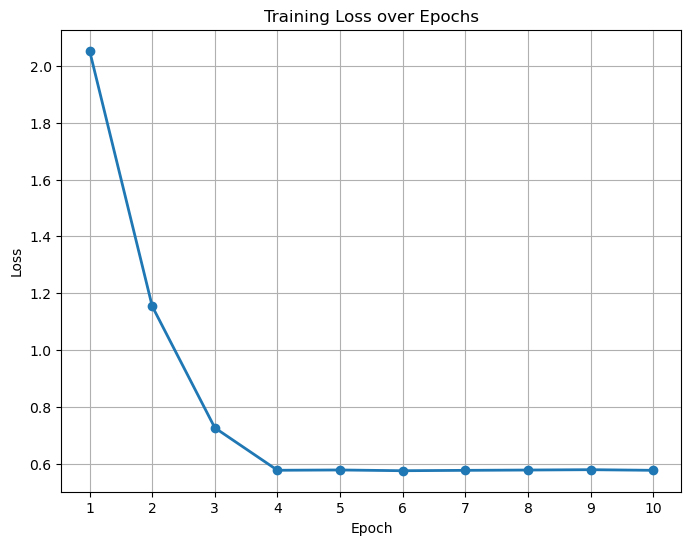

In [12]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(loss_arr) + 1), loss_arr, marker='o', linestyle='-', linewidth=2)
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(1, len(loss_arr) + 1))
plt.grid(True)
plt.show()